In [1]:
import pickle
import keras
import numpy as np

In [2]:
with open("test_qa.txt","rb") as fp:
    test_data = pickle.load(fp)

In [3]:
len(test_data)

1000

In [4]:
with open("train_qa.txt","rb") as fp:
    train_data = pickle.load(fp)

In [5]:
len(train_data)

10000

In [6]:
vocab = set()

In [7]:
all_data = train_data + test_data;

In [8]:
for story,question,answer in all_data:
    vocab=vocab.union(set(story))
    vocab=vocab.union(set(question))

In [9]:
vocab.add("yes")
vocab.add("no")

In [10]:
len(vocab)

37

In [11]:
vocab_len = len(vocab) + 1

In [12]:
max_story_length = max([len(data[0]) for data in all_data])

In [13]:
max_ques_length = max([len(data[1]) for data in all_data])

In [14]:
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer

In [15]:
tokenizer = Tokenizer(filters = [])

In [16]:
tokenizer.fit_on_texts(vocab)

In [17]:
tokenizer.word_index

{'put': 1,
 'left': 2,
 'dropped': 3,
 'up': 4,
 'to': 5,
 'the': 6,
 'bedroom': 7,
 'down': 8,
 'there': 9,
 'hallway': 10,
 'back': 11,
 'got': 12,
 'journeyed': 13,
 'took': 14,
 'bathroom': 15,
 'yes': 16,
 'in': 17,
 'mary': 18,
 'sandra': 19,
 'is': 20,
 'kitchen': 21,
 'picked': 22,
 'milk': 23,
 'football': 24,
 'travelled': 25,
 'john': 26,
 'office': 27,
 'discarded': 28,
 'garden': 29,
 'went': 30,
 'apple': 31,
 '?': 32,
 '.': 33,
 'grabbed': 34,
 'moved': 35,
 'daniel': 36,
 'no': 37}

In [18]:
train_story_text = []
train_question_text = []
train_answer = []

In [19]:
for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [20]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [1]:
#train_story_seq

In [22]:
def vectorize_stories(data, word_index = tokenizer.word_index, max_story_length = max_story_length, max_ques_length = max_ques_length):
    X = []
    Xq = []
    Y = []
    for story, question, answer in data:
        x=[word_index[word.lower()] for word in story]
        xq=[word_index[word.lower()] for word in question]
        y=np.zeros(len(word_index) + 1)
        y[word_index[answer]] = 1
    
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    
    return (pad_sequences(X,maxlen = max_story_length), 
            pad_sequences(Xq,maxlen = max_ques_length), 
            np.array(Y))    

In [23]:
inputs_train,queries_train,answer_train = vectorize_stories(train_data) 

In [24]:
inputs_test,queries_test,answer_test = vectorize_stories(test_data) 

In [25]:
inputs_train

array([[ 0,  0,  0, ...,  6,  7, 33],
       [ 0,  0,  0, ...,  6, 10, 33],
       [ 0,  0,  0, ...,  6, 15, 33],
       ...,
       [ 0,  0,  0, ...,  6,  7, 33],
       [ 0,  0,  0, ..., 23,  9, 33],
       [ 0,  0,  0, ..., 31,  9, 33]])

In [26]:
queries_train

array([[20, 19, 17,  6, 10, 32],
       [20, 36, 17,  6, 15, 32],
       [20, 36, 17,  6, 27, 32],
       ...,
       [20, 19, 17,  6, 10, 32],
       [20, 18, 17,  6, 21, 32],
       [20, 18, 17,  6,  7, 32]])

In [27]:
answer_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate,LSTM

In [29]:
input_sequence = Input((max_story_length))
question = Input((max_ques_length))

In [30]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim = vocab_len, output_dim = 64))
input_encoder_m.add(Dropout(0.3))

In [31]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim = vocab_len, output_dim = max_ques_length))
input_encoder_c.add(Dropout(0.3))

In [32]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim = vocab_len, output_dim = 64, input_length = max_ques_length))
question_encoder.add(Dropout(0.3))

In [33]:
input_encoded_m = input_encoder_m(input_sequence)

input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [34]:
match = dot([input_encoded_m,question_encoded], axes = (2,2))
match = Activation('softmax')(match)

In [35]:
response = add([match,input_encoded_c])
response = Permute((2,1))(response)

In [36]:
answer = concatenate([response,question_encoded ])

In [37]:
answer = LSTM(32)(answer)

In [38]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_len)(answer)

In [39]:
answer = Activation('softmax')(answer)

In [40]:
model = Model([input_sequence, question], answer)
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [42]:
history = model.fit([inputs_train, queries_train], answer_train,
                   batch_size = 32, epochs = 20,
                   validation_data = ([inputs_test, queries_test], answer_test)
                   )

Epoch 1/20
313/313 [==============================] - 11s 26ms/step - loss: 0.8914 - accuracy: 0.4899 - val_loss: 0.6946 - val_accuracy: 0.4970
Epoch 2/20
313/313 [==============================] - 8s 24ms/step - loss: 0.6984 - accuracy: 0.5007 - val_loss: 0.6933 - val_accuracy: 0.5030
Epoch 3/20
313/313 [==============================] - 7s 21ms/step - loss: 0.6957 - accuracy: 0.4957 - val_loss: 0.6960 - val_accuracy: 0.4970
Epoch 4/20
313/313 [==============================] - 7s 23ms/step - loss: 0.6941 - accuracy: 0.5023 - val_loss: 0.6991 - val_accuracy: 0.5030
Epoch 5/20
313/313 [==============================] - 7s 24ms/step - loss: 0.6954 - accuracy: 0.4962 - val_loss: 0.6947 - val_accuracy: 0.5030
Epoch 6/20
313/313 [==============================] - 7s 24ms/step - loss: 0.6947 - accuracy: 0.4978 - val_loss: 0.6952 - val_accuracy: 0.4970
Epoch 7/20
313/313 [==============================] - 8s 24ms/step - loss: 0.6946 - accuracy: 0.5018 - val_loss: 0.6934 - val_accuracy: 0.468

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 0, 'epochs')

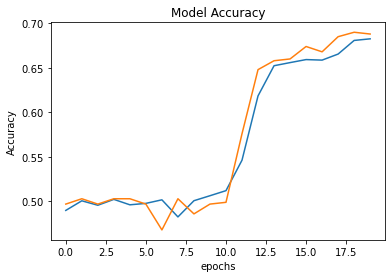

In [43]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epochs")


In [44]:
model.save('chatbot_model')

INFO:tensorflow:Assets written to: chatbot_model\assets


INFO:tensorflow:Assets written to: chatbot_model\assets


In [45]:
pred_results = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 1s 5ms/step


In [46]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [47]:
story = ' '.join(word for word in test_data[0][0])

In [48]:
story

'Mary got the milk there . John moved to the bedroom .'

In [49]:
query = ' '.join(word for word in test_data[0][1])

In [50]:
query

'Is John in the kitchen ?'

In [51]:
test_data[0][2]

'no'

In [52]:
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k=key
        
print("Predicted Answer is",k)
print("Probability of certainity", pred_results[0][val_max])

Predicted Answer is yes
Probability of certainity 0.66227543


In [53]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [54]:
story = "Mary dropped the football . Sandra discarded apple in kitchen . Daniel went to office ."
story.split()

['Mary',
 'dropped',
 'the',
 'football',
 '.',
 'Sandra',
 'discarded',
 'apple',
 'in',
 'kitchen',
 '.',
 'Daniel',
 'went',
 'to',
 'office',
 '.']

In [55]:
my_question = "Is Daniel in the office ? "
my_question.split()

['Is', 'Daniel', 'in', 'the', 'office', '?']

In [56]:
mydata = [(story.split(), my_question.split(), 'yes')]

In [57]:
my_story, my_ques, my_ans = vectorize_stories(mydata)

In [58]:
pred_results = model.predict(([my_story, my_ques]))

1/1 [==============================] - 0s 21ms/step


In [59]:
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k=key
        
print("Predicted Answer is",k)
print("Probability of certainity", pred_results[0][val_max])

Predicted Answer is yes
Probability of certainity 0.66717684
